In [1]:
import shelve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from patsy import dmatrices
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.stats import rv_discrete
from skopt import Optimizer, space


In [2]:
#initialize dataframe, lines calculated with function to be explained later, xgs extracted from footystats sheets
season2021 =pd.read_csv("combinefd21.csv")
season2022 =pd.read_csv("combinefd22.csv")
season2023 =pd.read_csv("combinefd23.csv")
df = pd.concat([season2021, season2022, season2023]).reset_index(drop=True)
print(len(season2021))
print(len(season2022))
with shelve.open('inputs') as i:
    hls = i['hls']
    als = i['als']
df.insert(5, 'A_Line', als)
df.insert(5, 'H_Line', hls)
df.head(5)

7633
7821


,Div,Date,Time,HomeTeam,AwayTeam,H_Line,A_Line,FTHG,FTAG,HXG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SC0,08/01/20,12:30,Aberdeen,Rangers,0.724756,1.770761,0,1,0.67,...,1.78,1.00,1.83,2.02,1.90,2.00,1.94,2.12,1.85,1.99
1,SC0,08/01/20,15:00,Dundee United,St Johnstone,1.094679,1.066453,1,1,1.49,...,1.52,0.00,1.93,1.93,1.91,1.99,2.00,1.99,1.92,1.93
2,SC0,08/01/20,15:00,Hibernian,Kilmarnock,1.511150,0.977880,2,1,1.24,...,1.76,-0.50,1.95,1.90,1.96,1.94,2.02,1.94,1.95,1.88
3,SC0,08/01/20,15:00,St Mirren,Livingston,0.945194,1.182613,1,0,0.94,...,1.53,0.25,1.85,2.00,1.88,2.01,1.90,2.08,1.83,2.01
4,SC0,08/02/20,16:30,Celtic,Hamilton,3.534317,0.420098,5,1,3.07,...,3.79,-3.00,1.98,1.88,2.01,1.88,2.04,1.92,1.96,1.87


In [3]:
def gather_data(decay): # decay factor used to compute weighted averages for recency
    # dictionaries to store stats for each team
    goals_for = {}
    goals_ag = {}
    xgoals_for = {}
    xgoals_ag = {}
    lines_for = {}
    lines_ag = {}

    # parameter names for the metrics
    param_names = ['goals', 'loglines']
    param_names += ['xgoals_lines_for', 'goals_xgoals_for', 
                    'goals_lines_for','wxgoals_lines_for', 
                    'wgoals_xgoals_for', 'wgoals_lines_for']
    param_names += ['xgoals_lines_ag', 'goals_xgoals_ag', 
                    'goals_lines_ag','wxgoals_lines_ag', 
                    'wgoals_xgoals_ag', 'wgoals_lines_ag']

    # minimum sample size for teams before betting on a match
    min_sample_size = 8

    # list to store training data rows
    training_rows = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows(): 
        if index == 7633 or index == 7633+7821:
            goals_for = {}
            goals_ag = {}
            xgoals_for = {}
            xgoals_ag = {}
            lines_for = {}
            lines_ag = {}
            
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        h_line = row['H_Line']
        a_line = row['A_Line']
        h_goals = row['FTHG']
        a_goals = row['FTAG']

        # Check if both teams have sufficient data for betting
        if home_team in goals_for and away_team in goals_for and len(goals_for[home_team]) >= min_sample_size and len(goals_for[away_team]) >= min_sample_size:

            # Calculate various metrics for home and away teams
            h_xgoals_vs_lines_for, h_goals_vs_lines_for, h_goals_vs_xgoals_for, h_xgoals_vs_lines_ag, h_goals_vs_lines_ag, h_goals_vs_xgoals_ag = metrics(home_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag)
            a_xgoals_vs_lines_for, a_goals_vs_lines_for, a_goals_vs_xgoals_for, a_xgoals_vs_lines_ag, a_goals_vs_lines_ag, a_goals_vs_xgoals_ag = metrics(away_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag)
            weighted_h_xgoals_vs_lines_for, weighted_h_goals_vs_lines_for, weighted_h_goals_vs_xgoals_for, weighted_h_xgoals_vs_lines_ag, weighted_h_goals_vs_lines_ag, weighted_h_goals_vs_xgoals_ag = metrics(home_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag, True, decay)
            weighted_a_xgoals_vs_lines_for, weighted_a_goals_vs_lines_for, weighted_a_goals_vs_xgoals_for, weighted_a_xgoals_vs_lines_ag, weighted_a_goals_vs_lines_ag, weighted_a_goals_vs_xgoals_ag = metrics(away_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag, True, decay)

            # Apply the convert_metric function to each metric for home and away teams
            home_metrics = [h_xgoals_vs_lines_for, h_goals_vs_lines_for, h_goals_vs_xgoals_for, weighted_h_xgoals_vs_lines_for, weighted_h_goals_vs_lines_for, weighted_h_goals_vs_xgoals_for]
            home_metrics += [a_xgoals_vs_lines_ag, a_goals_vs_lines_ag, a_goals_vs_xgoals_ag, weighted_a_xgoals_vs_lines_ag, weighted_a_goals_vs_lines_ag, weighted_a_goals_vs_xgoals_ag]
            away_metrics = [a_xgoals_vs_lines_for, a_goals_vs_lines_for, a_goals_vs_xgoals_for, weighted_a_xgoals_vs_lines_for, weighted_a_goals_vs_lines_for, weighted_a_goals_vs_xgoals_for]
            away_metrics += [h_xgoals_vs_lines_ag, h_goals_vs_lines_ag, h_goals_vs_xgoals_ag, weighted_h_xgoals_vs_lines_ag, weighted_h_goals_vs_lines_ag, weighted_h_goals_vs_xgoals_ag]

            for i in range(12):
                home_metrics[i] = convert_metric(h_line, home_metrics[i])
                away_metrics[i] = convert_metric(a_line, away_metrics[i])

            # Create complete metrics Series for home and away teams
            complete_home_metrics = pd.Series([h_goals, np.log(h_line)]+home_metrics,index=param_names)
            complete_away_metrics = pd.Series([a_goals, np.log(a_line)]+away_metrics,index=param_names)

            # Append the metrics Series to the training_rows list
            training_rows.append(complete_home_metrics)
            training_rows.append(complete_away_metrics)

        # Update the dictionaries with new data for goals, expected goals, and lines
        h_xg = row['HXG']
        a_xg = row['AXG']
        goals_for[home_team] = goals_for.setdefault(home_team, [])+[h_goals]
        goals_for[away_team] = goals_for.setdefault(away_team, [])+[a_goals]
        goals_ag[home_team] = goals_ag.setdefault(home_team, [])+[a_goals]
        goals_ag[away_team] = goals_ag.setdefault(away_team, [])+[h_goals]
        xgoals_for[home_team] = xgoals_for.setdefault(home_team, [])+[h_xg]
        xgoals_for[away_team] = xgoals_for.setdefault(away_team, [])+[a_xg]
        xgoals_ag[home_team] = xgoals_ag.setdefault(home_team, [])+[a_xg]
        xgoals_ag[away_team] = xgoals_ag.setdefault(away_team, [])+[h_xg]
        lines_for[home_team] = lines_for.setdefault(home_team, [])+[h_line]
        lines_for[away_team] = lines_for.setdefault(away_team, [])+[a_line]
        lines_ag[home_team] = lines_ag.setdefault(home_team, [])+[a_line]
        lines_ag[away_team] = lines_ag.setdefault(away_team, [])+[h_line]
    return training_rows


In [4]:
# Initialize empty lists to store test decays and losses
test_decays = []
losses = []

# Define the compute_loss function with decay as the input
def compute_loss(decay):
    # Gather training data based on the decay value
    training_rows = gather_data(decay)
    
    # Concatenate the training data horizontally and transpose it
    data = pd.concat(training_rows, axis=1).T
    
    # Define the initial expression with the dependent variable 'goals' and the independent variable 'loglines'
    expr = 'goals ~ loglines'
    
    # Append the remaining column names to the expression
    for name in data.columns[2:]:
        expr += ' + ' + name
    
    # Create design matrices (y_train, X_train) using the formula expr and the data
    y_train, X_train = dmatrices(expr, data, return_type='dataframe')
    
    # Fit the model on the training data
    result = fit(X_train, y_train)
    
    # Calculate the parameters, considering values below a certain threshold as 0
    params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
    
    # Compute the loss based on the optimized parameters
    loss = result.fun
    
    # Print the decay and loss values
    print(decay, loss)
    
    # Append the decay and loss to the respective lists
    test_decays.append(decay)
    losses.append(loss)
    
    # Return the computed loss
    return loss

In [5]:
# Initialize the best_loss variable with infinity
best_loss = float('inf')

# Iterate over a range of values from 5 to 9 (inclusive)
for i in range(5, 10):
    # Compute the loss for the current decay value
    loss = compute_loss(i / 10)
    
    # Update the best_loss and best_decay variables if the current loss is smaller
    if loss < best_loss:
        best_loss = loss
        best_decay = i / 10

# Compute a seed value based on the best_decay
seed = int(best_decay * 100)

# Iterate over a range of values from seed-5 to seed+5
for i in range(seed - 5, seed + 6):
    # Compute the loss for the current decay value
    loss = compute_loss(i / 100)
    
    # Update the best_loss and best_decay variables if the current loss is smaller
    if loss < best_loss:
        best_loss = loss
        best_decay = i / 100

# Iterate over a range of values from 95 to 99
for i in range(95, 100):
    # Compute the loss for the current decay value
    loss = compute_loss(i / 100)
    
    # Update the best_loss and best_decay variables if the current loss is smaller
    if loss < best_loss:
        best_loss = loss
        best_decay = i / 100


0.5 1.4147040538759068
0.6 1.4146993097229448
0.7 1.4146891196291453
0.8 1.4146695977335835
0.9 1.414649507472981
0.85 1.4146584504957167
0.86 1.41465637427215
0.87 1.4146544263076066
0.88 1.4146526121663345
0.89 1.4146509635623503
0.9 1.414649507472981
0.91 1.4146482962434348
0.92 1.414647338386015
0.93 1.414646707655017
0.94 1.4146464304251236
0.95 1.4146465890314712
0.95 1.4146465890314712
0.96 1.4147106613811347
0.97 1.4147096375885022
0.98 1.4147085104928534
0.99 1.4147086094711447


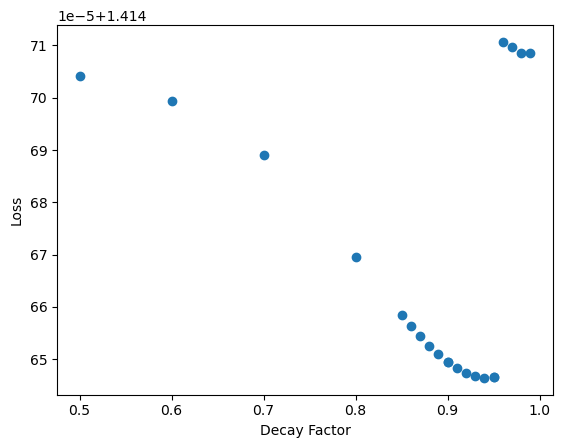

In [6]:
# Scatter plot of decay values vs. losses
plt.scatter(test_decays, losses)
plt.xlabel('Decay Factor')
plt.ylabel('Loss')
plt.show()

# Gather the training data based on the best decay value
training_rows = gather_data(best_decay)
data = pd.concat(training_rows, axis=1).T


In [ ]:
expr = 'goals ~ loglines'
for name in data.columns[2:]:
    expr += ' + '+name

l1_wts = []
l2_wts = []
cv_losses = []

def cross_validate(l1_wt, l2_wt):
    # Split the data into training and test sets
    df_train = data[:round(len(data)*.8)]
    df_test = data[round(len(data)*.8):]
    
    # Create design matrices for training and test data
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    
    # Fit regularized model on the training data
    result = fit_regularized(X_train, y_train, l1_wt, l2_wt)
    params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
    null = [0,1]+[0]*(len(params)-2)
    
    # Calculate the loss difference between the model and null model on the test data
    loss = objective_function(params, X_test, y_test) - objective_function(null, X_test, y_test)
    
    # Store the l1_wt, l2_wt, and loss values for analysis
    l1_wts.append(l1_wt)
    l2_wts.append(l2_wt)
    cv_losses.append(loss)
    
    return loss

def objective(x):
    l1_wt, l2_wt = x
    return cross_validate(l1_wt, l2_wt)

sp = [space.Real(1e-10, .001, name='l1_wt', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt', prior='log-uniform')]
# Create an instance of Optimizer for Bayesian optimization and optimize
optimizer = Optimizer(sp, base_estimator='gp')
# Perform Bayesian optimization iterations
_ = optimizer.run(objective, 500)


C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [ ]:
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(l1_wts, l2_wts, c=cv_losses, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Loss')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Experimental Responses')

# Display the plot
plt.show()

# Find optimal point
A=np.linspace(0.001, 1, 1000)
B=np.linspace(0.001, 1, 1000)
points = []
for a in A:
    for b in B:
        points.append(np.array([a, b]))
surrogate_model = optimizer.models[-1]
scores = np.array([surrogate_model.predict(point.reshape(1,-1)) for point in points])
f_l1_wts = []
f_l2_wts = []
f_cv_losses = []
for point, score in zip(points, scores):
    conv = point.copy()
    i = -10
    j1 = -3
    j2 = -1
    conv[0] = 10**(conv[0]*(j1-i)+i)
    conv[1] = 10**(conv[1]*(j2-i)+i)
    f_l1_wts.append(conv[0])
    f_l2_wts.append(conv[1])
    f_cv_losses.append(score)
    
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(f_l1_wts, f_l2_wts, c=f_cv_losses, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Loss')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Fitted Responses')

# Display the plot
plt.show()  

#find the best predicted point
argmin = np.argmin(scores)
point = points[argmin]
conv = point.copy()
i = -10
j1 = -3
j2 = -1
conv[0] = 10**(conv[0]*(j1-i)+i)
conv[1] = 10**(conv[1]*(j2-i)+i)
print(point, conv, scores[argmin])

In [ ]:
#train model with tuned parameters on all data
y, X = dmatrices(expr, data, return_type='dataframe')
best_l1_wt, best_l2_wt =conv
result = fit_regularized(X, y, best_l1_wt,best_l2_wt)
params = np.where(np.abs(result.x) <= 1e-5, 0, result.x) 


In [ ]:
# Graph performance of the model to evaluate smoothness
beta = params
null = [0,1]+[0]*(X.shape[1]-2)
alpha = -0.024
y_flat = y.values.flatten()
mu_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ beta)))
null_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ null)))
game = list(range(len(mu_errors))) 
plt.scatter(game, np.cumsum(mu_errors-null_errors))
plt.xlabel('Game')
plt.ylabel('Performance')
plt.show()


In [ ]:
# Idea 2: given the null, compute the distribution of losses between the null and alternative and return the z-score assuming
# that sum of all the difference is approximately normal
# Extract the 'loglines' values from the X DataFrame starting from 80% of the length
lines = np.exp(X['loglines'][round(len(X)*.8):])

# Function to create distributions and losses
def create_dists(lines):
    dists = []  # List to store probability distributions
    losses = []  # List to store losses

    # Iterate over lines and preds
    for line, pred in zip(lines, preds):
        probs = []  # List to store individual probabilities
        l = []  # List to store individual losses
        i = 0
        cum = 0.0
        
        # Calculate probabilities and losses until cumulative probability exceeds 0.9999
        while cum < 0.9999:
            pmf = gpmf(i, -0.024, line)  # Calculate the probability mass function
            pmf_item = pmf.item()  # Extract the value of the probability mass function
            cum += pmf_item  # Update the cumulative probability
            probs.append(pmf_item)  # Append the probability to the list of probabilities
            l.append(-np.log(pmf_item))  # Append the loss to the list of losses
            i += 1

        dists.append(probs + [1.0 - cum])  # Append the probabilities with the remaining probability to the dists list
        losses.append(l + [-np.log(1.0 - cum)])  # Append the losses with the final loss to the losses list

    return dists, losses

# Call the create_dists function to compute dists and losses
dists, losses = create_dists(lines)


In [ ]:
expr = 'goals ~ loglines'
# Iterate over the columns of the data DataFrame starting from the third column
for name in data.columns[2:]:
    expr += ' + '+name  # Append column names to the expression for linear regression

l1_wts = []  # List to store l1_wt values
l2_wts = []  # List to store l2_wt values
cv_scores = []  # List to store cross-validation scores

# Function for cross-validation
def cross_validate(l1_wt, l2_wt):   
    # Split the data into training and test sets
    df_train = data[:round(len(data)*.8)]
    df_test =  data[round(len(data)*.8):]  
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    
    # Fit a regularized linear regression model
    result = fit_regularized(X_train, y_train, l1_wt, l2_wt)
    params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)  # Threshold parameters close to zero
    null = [0,1]+[0]*(len(params)-2)  # Null model parameters

    preds = np.exp(X_test @ params)  # Generate predictions using the fitted model

    rvs = []  # List to store random variables
    for pred, loss, dist in zip(preds, losses, dists):
        loss_diff = []
        # Calculate the difference between predicted and actual losses for each observation
        for i in range(len(loss)):
            pred_pmf = gpmf(i, -.024, pred)
            loss_diff.append(-np.log(pred_pmf)-loss[i])
        rv = rv_discrete(values=(loss_diff, dist))  # Create a random variable with the loss differences and distribution
        rvs.append(rv)

    mean = var = 0
    for rv in rvs:
        mean += rv.mean()  # Compute the mean of the random variables
        var += rv.var()  # Compute the variance of the random variables
    
    std = np.sqrt(var)  # Calculate the standard deviation
    model_loss = objective_function(params, X_test, y_test)  # Calculate the loss of the model predictions
    null_loss = objective_function([0,1]+[0]*(len(params)-2), X_test, y_test)  # Calculate the loss of the null model
    x = (model_loss-null_loss)*len(X_test)  # Compute the difference in losses scaled by the number of observations
    l1_wts.append(l1_wt)
    l2_wts.append(l2_wt)
    score = (x-mean)/std  # Compute the cross-validation score
    cv_scores.append(score)
    
    return score

def objective(x):
    l1_wt, l2_wt = x
    return cross_validate(l1_wt, l2_wt)

sp = [space.Real(1e-10, .001, name='l1_wt', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt', prior='log-uniform')]
# Create an instance of Optimizer for Bayesian optimization and optimize
optimizer = Optimizer(sp, base_estimator='gp')
# Perform Bayesian optimization iterations
_ = optimizer.run(objective, 500)


In [ ]:
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(l1_wts, l2_wts, c=cv_scores, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Score')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Experimental Responses')

# Display the plot
plt.show()

# Find optimal point
A=np.linspace(0.001, 1, 1000)
B=np.linspace(0.001, 1, 1000)
points = []
for a in A:
    for b in B:
        points.append(np.array([a, b]))
surrogate_model = optimizer.models[-1]
scores = np.array([surrogate_model.predict(point.reshape(1,-1)) for point in points])
f_l1_wts = []
f_l2_wts = []
f_cv_losses = []
for point, score in zip(points, scores):
    conv = point.copy()
    i = -10
    j1 = -3
    j2 = -1
    conv[0] = 10**(conv[0]*(j1-i)+i)
    conv[1] = 10**(conv[1]*(j2-i)+i)
    f_l1_wts.append(conv[0])
    f_l2_wts.append(conv[1])
    f_cv_losses.append(score)
    
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(f_l1_wts, f_l2_wts, c=f_cv_losses, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Loss')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Fitted Responses')

# Display the plot
plt.show()  

argmin = np.argmin(scores)
point = points[argmin]
conv = point.copy()
i = -10
j1 = -3
j2 = -1
conv[0] = 10**(conv[0]*(j1-i)+i)
conv[1] = 10**(conv[1]*(j2-i)+i)
print(point, conv, scores[argmin])

In [ ]:
#train model with tuned parameters on all data
y, X = dmatrices(expr, data, return_type='dataframe')
best_l1_wt, best_l2_wt =conv
result = fit_regularized(X, y, best_l1_wt,best_l2_wt)
params = np.where(np.abs(result.x) <= 1e-5, 0, result.x) 
print(params)

#graph performance
beta = params
null = [0,1]+[0]*(X.shape[1]-2)
alpha = -0.024
y_flat = y.values.flatten()
mu_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ beta)))
null_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ null)))
game = list(range(len(mu_errors))) 
plt.scatter(game, np.cumsum(mu_errors-null_errors))
plt.xlabel('Game')
plt.ylabel('Performance')
plt.show()